### Import Required Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
import re

### Load the dataset

In [17]:
df = pd.read_csv("datasets.csv")
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Visualize the data

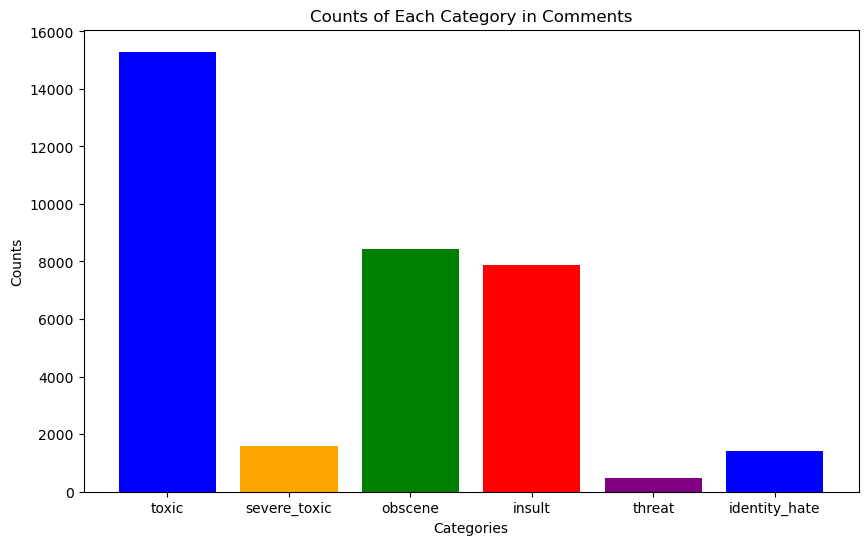

In [6]:
counts = {
    'toxic': df['toxic'].sum(),
    'severe_toxic': df['severe_toxic'].sum(),
    'obscene': df['obscene'].sum(),
    'insult': df['insult'].sum(),
    'threat': df['threat'].sum(),
    'identity_hate': df['identity_hate'].sum()
}

# Create a bar plot
labels = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Each Category in Comments')
plt.show()

### Drop the columns

In [18]:
df.drop(['id'], axis=1, inplace=True)

In [19]:
df.drop(['severe_toxic'], axis=1, inplace=True)

In [20]:
df.drop(['threat'], axis=1, inplace=True)

In [21]:
df.drop(['identity_hate'], axis=1, inplace=True)

### Removing rows to make the class balance

In [22]:
df_non_toxic = df[(df[['toxic','obscene','insult']] == 0).all(axis=1)]
if len(df_non_toxic) > 20000:
    df_non_toxic = df_non_toxic.sample(n=20000, random_state=42)

In [23]:
df_toxic = df[(df[['toxic','obscene','insult']] != 0).any(axis=1)]
df_combined = pd.concat([df_toxic, df_non_toxic])

In [9]:
df_combined

,comment_text,toxic,obscene,insult
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,1,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,1,1
...,...,...,...,...
79817,"""\n You are right in your assumption that ther...",0,0,0
146943,nonsense Pages\n\nPlease stop posting nonsense...,0,0,0
41437,the article is fine as is,0,0,0
1499,"""\nAgreed, but how would you describe it ? It ...",0,0,0


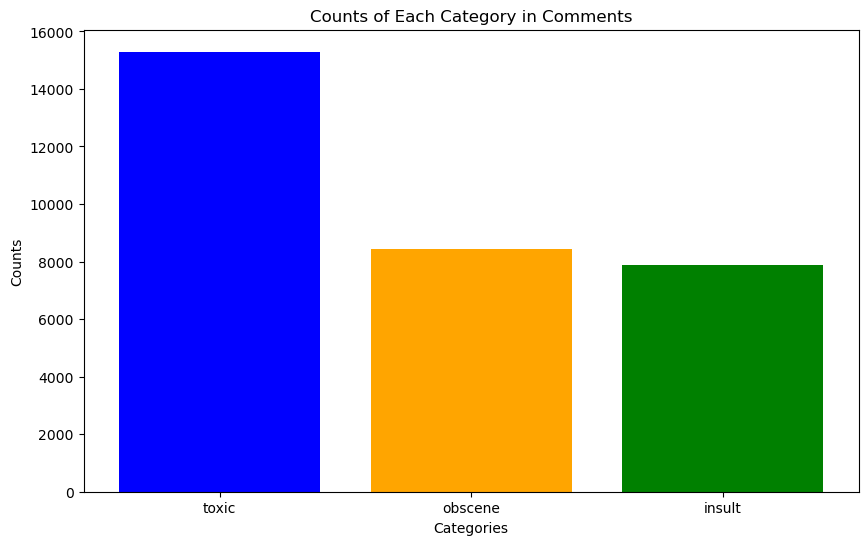

In [14]:
counts = {
    'toxic': df_combined['toxic'].sum(),
    'obscene':df_combined['obscene'].sum(),
    'insult': df_combined['insult'].sum(),
}

# Create a bar plot
labels = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Each Category in Comments')
plt.show()

### Exploratory Data Analysis

In [10]:
df_combined.shape

(36149, 4)

In [11]:
df_combined.isna().sum()

comment_text    0
toxic           0
obscene         0
insult          0
dtype: int64

In [12]:
df_combined['toxic'].value_counts()

toxic
0    20855
1    15294
Name: count, dtype: int64

In [13]:
df_combined['obscene'].value_counts()

obscene
0    27700
1     8449
Name: count, dtype: int64

In [14]:
df_combined['insult'].value_counts()

insult
0    28272
1     7877
Name: count, dtype: int64

### Text Preprocessing

In [24]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tsheltrimpemo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tsheltrimpemo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tsheltrimpemo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsheltrimpemo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tsheltrimpemo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
def prepare_text(text):
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = word_tokenize(text)
    text = pos_tag(text)
    lemma = [wordnet_lemmatizer.lemmatize(i[0], pos=get_wordnet_pos(i[1])) for i in text]
    lemma = ' '.join(lemma)
    return lemma


In [26]:
wordnet_lemmatizer = WordNetLemmatizer()

In [27]:
df_combined['clean_comment_text'] = df_combined['comment_text'].apply(lambda x: prepare_text(x))

In [29]:
df_combined

,comment_text,toxic,obscene,insult,clean_comment_text
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,Hey what be it talk What be it an exclusive gr...
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,Bye Don t look come or think of comming back T...
42,You are gay or antisemmitian? \n\nArchangel WH...,1,1,1,You be gay or antisemmitian Archangel WHite Ti...
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,1,1,FUCK YOUR FILTHY MOTHER IN THE ASS DRY
...,...,...,...,...,...
79817,"""\n You are right in your assumption that ther...",0,0,0,You be right in your assumption that there be ...
146943,nonsense Pages\n\nPlease stop posting nonsense...,0,0,0,nonsense Pages Please stop post nonsense to th...
41437,the article is fine as is,0,0,0,the article be fine a be
1499,"""\nAgreed, but how would you describe it ? It ...",0,0,0,Agreed but how would you describe it It be not...


In [30]:
df_combined.drop(['comment_text'], axis=1, inplace=True)

In [31]:
df_combined.to_csv('clean_comment_text.csv',index=False)

In [32]:
df=pd.read_csv('clean_comment_text.csv')
df.head()

,toxic,obscene,insult,clean_comment_text
0,1,1,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
1,1,0,0,Hey what be it talk What be it an exclusive gr...
2,1,0,0,Bye Don t look come or think of comming back T...
3,1,1,1,You be gay or antisemmitian Archangel WHite Ti...
4,1,1,1,FUCK YOUR FILTHY MOTHER IN THE ASS DRY


In [33]:
# Create TF-IDF matrix
corpus = df['clean_comment_text'].values.astype('U')
stopwords = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(corpus)

### Data Splitting

In [34]:
# List of toxicity labels
toxicity_labels = ['toxic', 'obscene', 'insult']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tf_idf, df[toxicity_labels], test_size=0.2, random_state=42)

## Model Training

### Before Oversampling

Training and evaluating for label: toxic


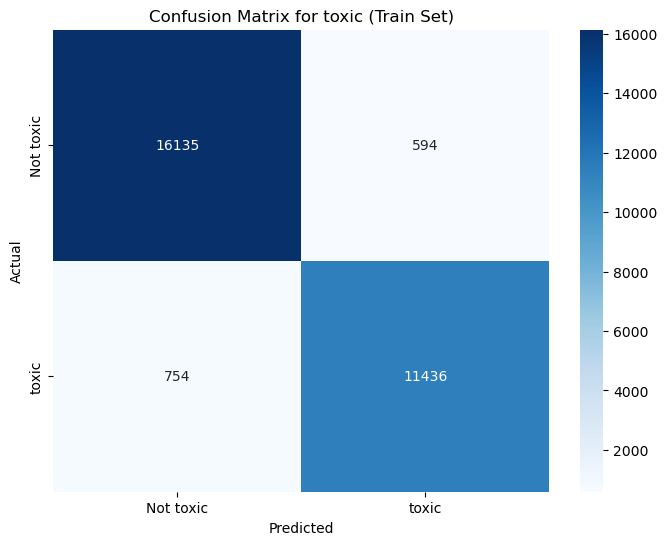

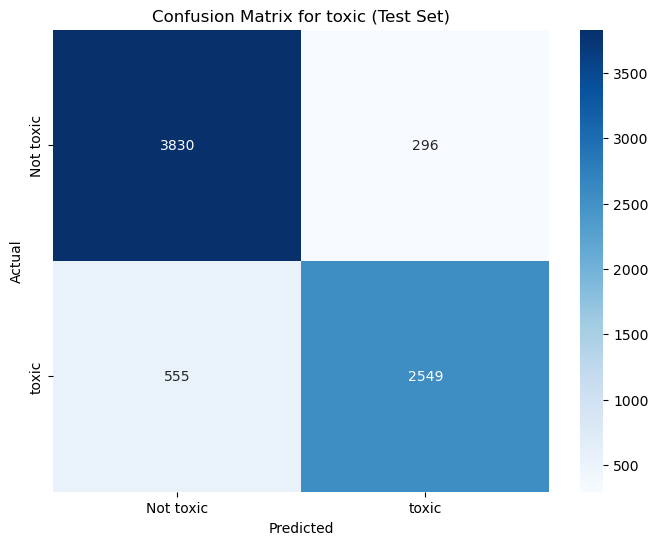

Training and evaluating for label: obscene


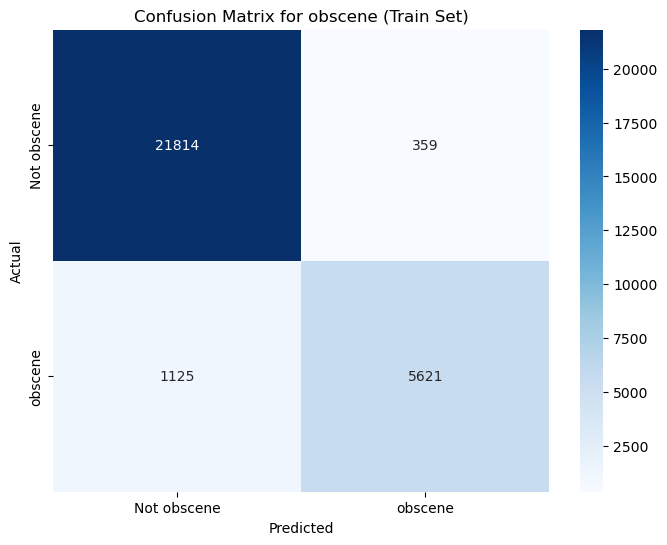

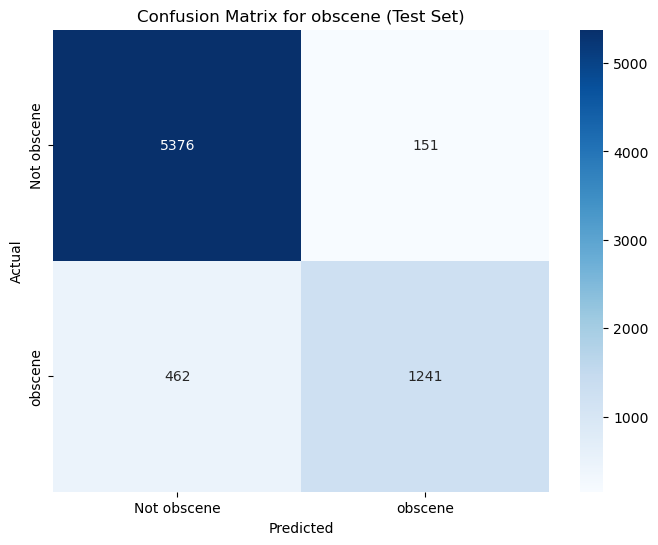

Training and evaluating for label: insult


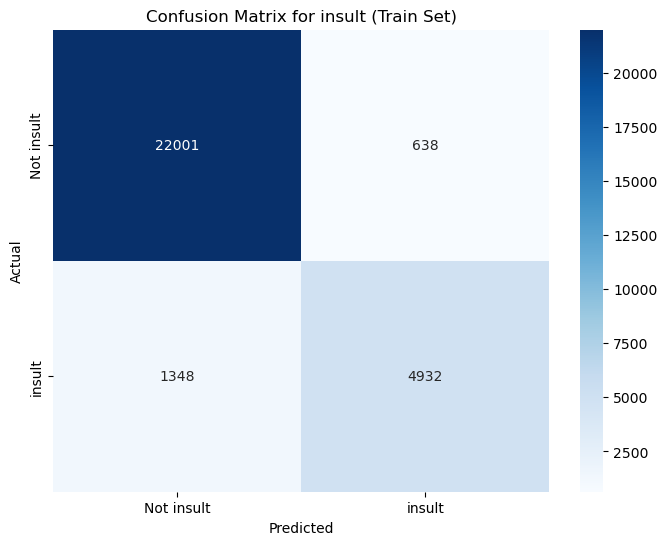

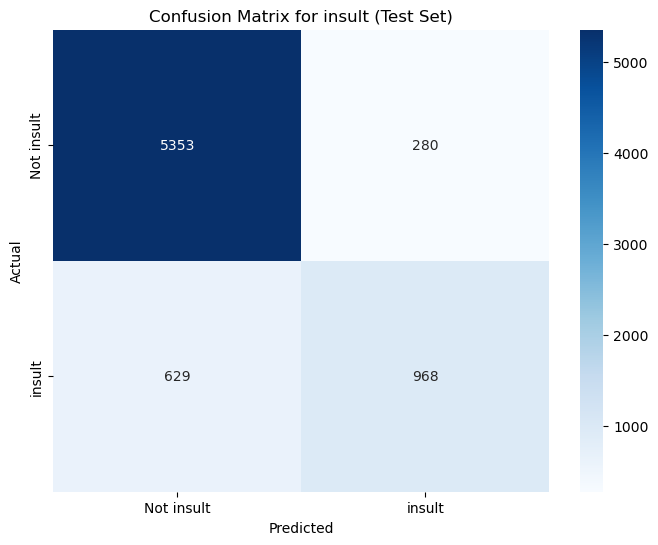


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9443
F1 Score for obscene (train set): 0.8834
F1 Score for insult (train set): 0.8324

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8570
F1 Score for obscene (test set): 0.8019
F1 Score for insult (test set): 0.6805


In [34]:
f1_scores_train = {}
conf_matrices_train = {}
f1_scores_test = {}
conf_matrices_test = {}

for toxicity_type in toxicity_labels:
    print(f"Training and evaluating for label: {toxicity_type}")
    
    svc_model = SVC(kernel='linear')
    svc_model.fit(X_train, y_train[toxicity_type])
    
    # Make predictions on the training set
    y_train_pred = svc_model.predict(X_train)
    
    # Calculate F1 score for the training set
    f1_train = f1_score(y_train[toxicity_type], y_train_pred)
    f1_scores_train[toxicity_type] = f1_train
    
    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train[toxicity_type], y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train
    
    # Make predictions on the test set
    y_test_pred = svc_model.predict(X_test)
    
    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test
    
    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test
    
    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")

### After Oversampling

Applying SMOTE and training for label: toxic


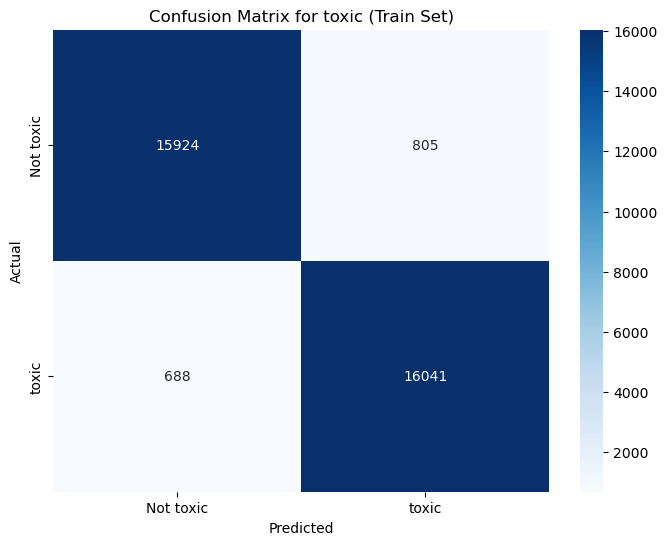

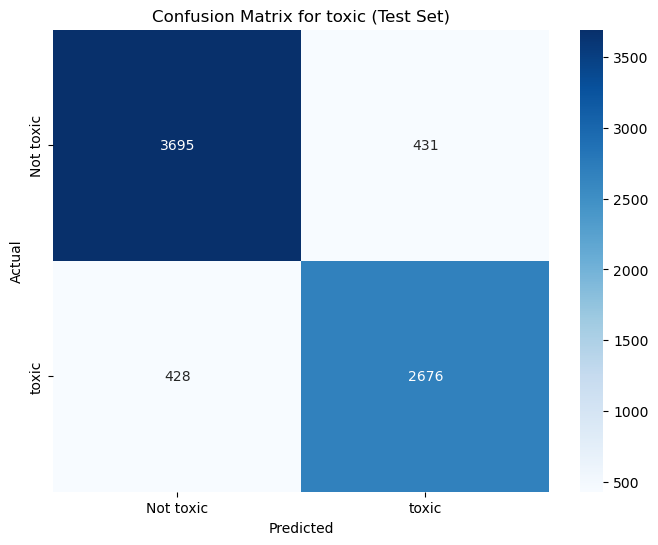

Applying SMOTE and training for label: obscene


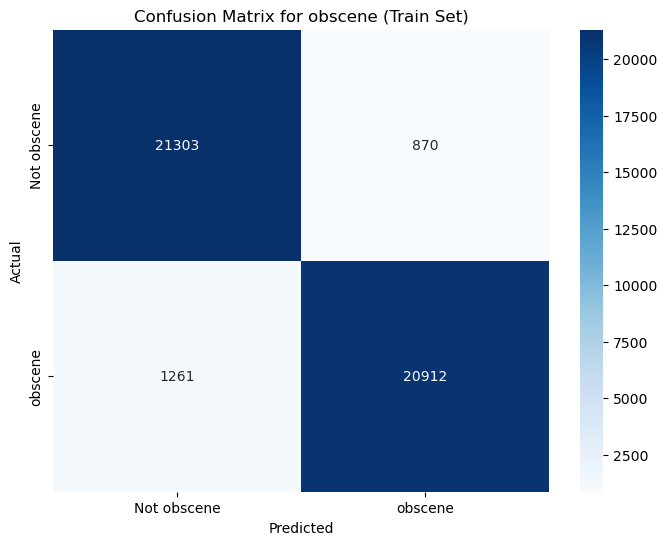

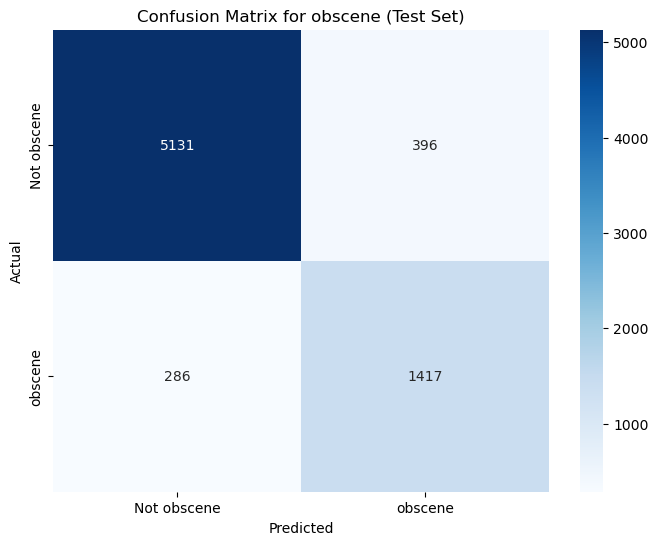

Applying SMOTE and training for label: insult


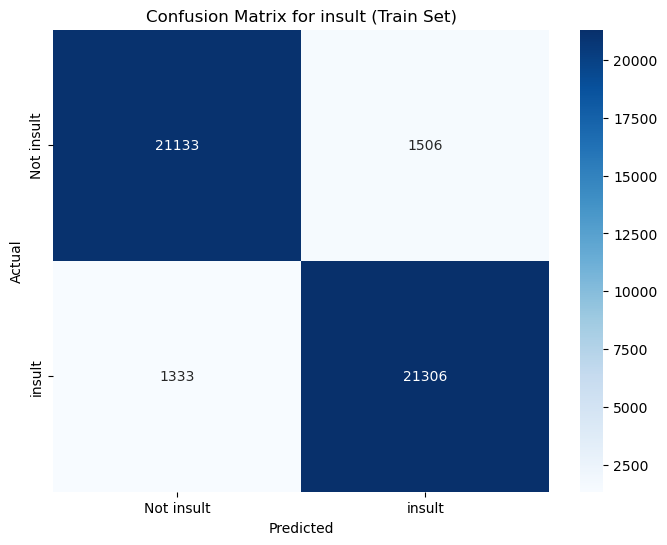

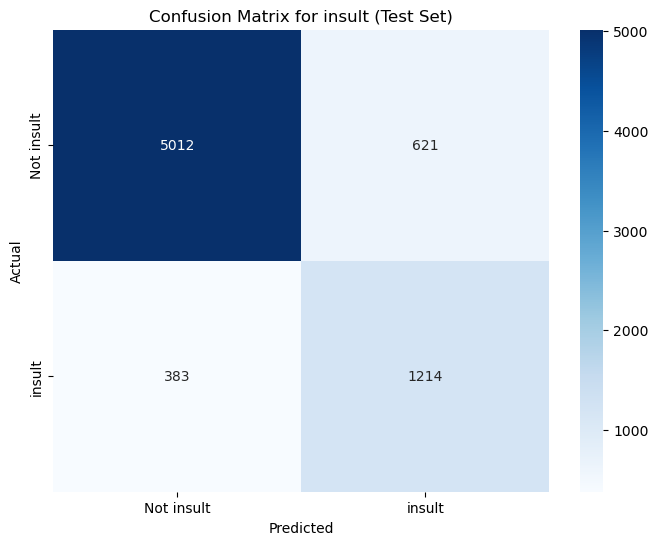


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9555
F1 Score for obscene (train set): 0.9515
F1 Score for insult (train set): 0.9375

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8617
F1 Score for obscene (test set): 0.8060
F1 Score for insult (test set): 0.7075


In [63]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Train SVM model
    svc_model = SVC(kernel='linear')
    svc_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the training set
    y_train_pred = svc_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = svc_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")

### Hyper Tunning (SVM)

Applying SMOTE and training for label: toxic


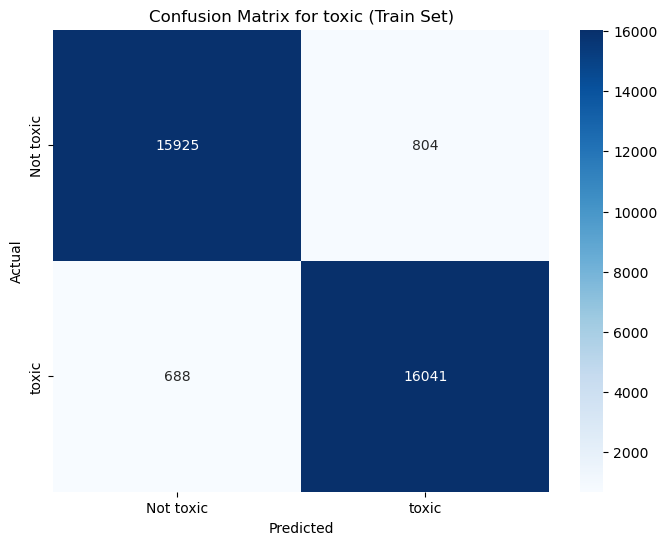

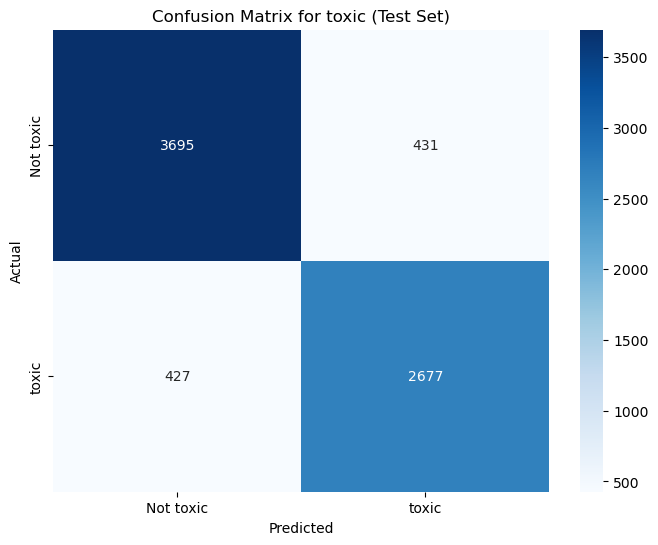

Applying SMOTE and training for label: obscene


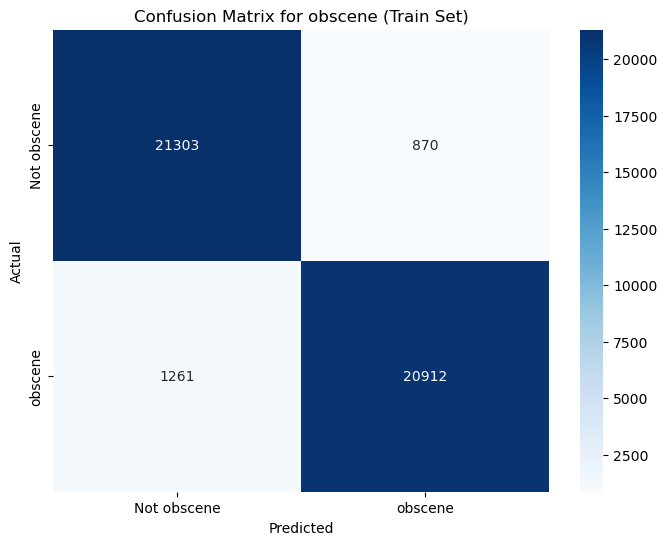

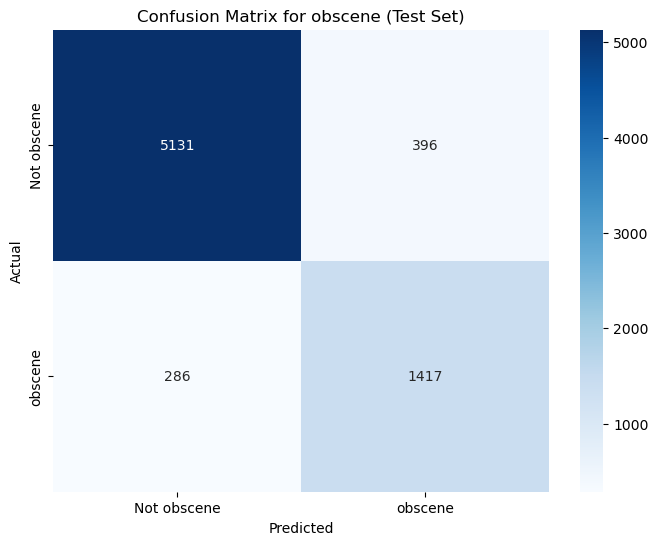

Applying SMOTE and training for label: insult


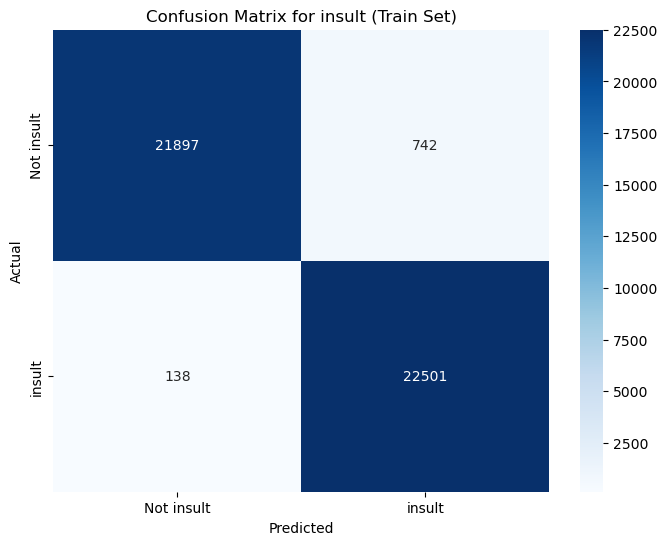

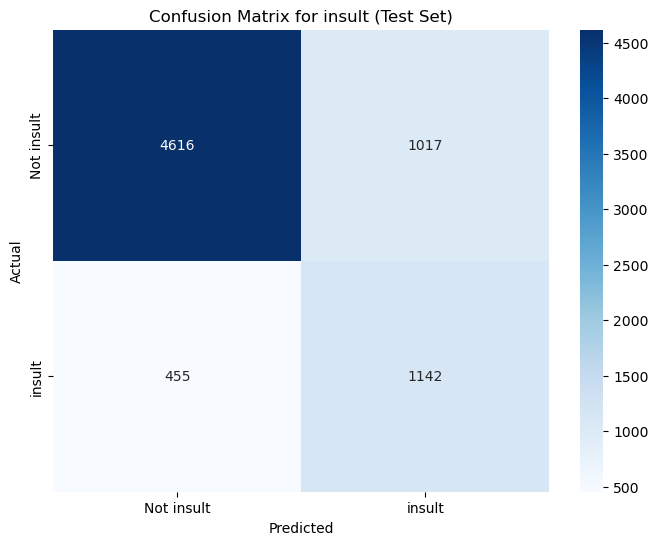


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9556
F1 Score for obscene (train set): 0.9515
F1 Score for insult (train set): 0.9808

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8619
F1 Score for obscene (test set): 0.8060
F1 Score for insult (test set): 0.6081


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Parameter grid for GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Set up the SVM model with GridSearchCV to find the best C parameter
    svc_model = SVC(kernel='linear')
    grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model from grid search
    best_svc_model = grid_search.best_estimator_

    # Make predictions on the training set
    y_train_pred = best_svc_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_svc_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


### Regulization (SVM)

Applying SMOTE and training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for toxic: {'C': 1, 'dual': False, 'penalty': 'l2'}


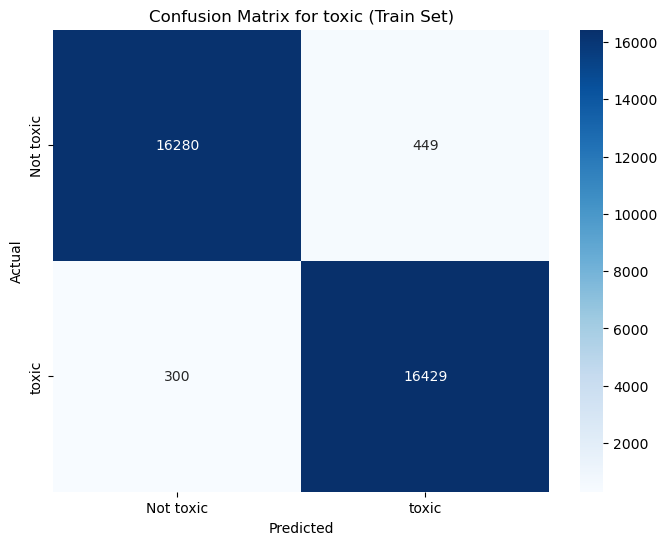

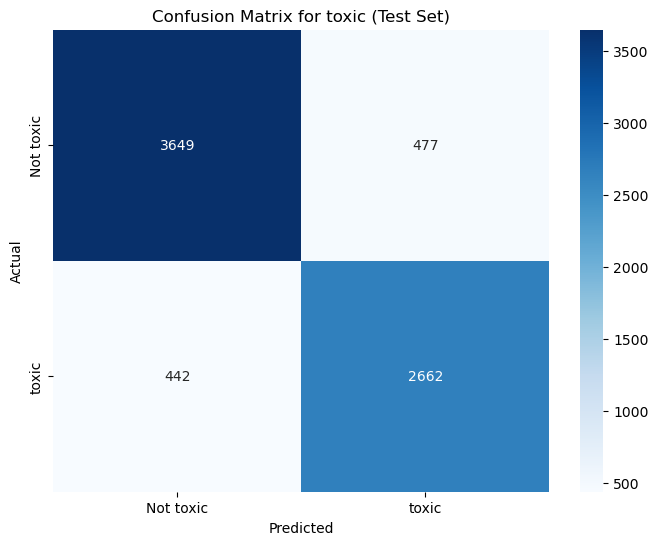

Applying SMOTE and training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for obscene: {'C': 1, 'dual': False, 'penalty': 'l2'}


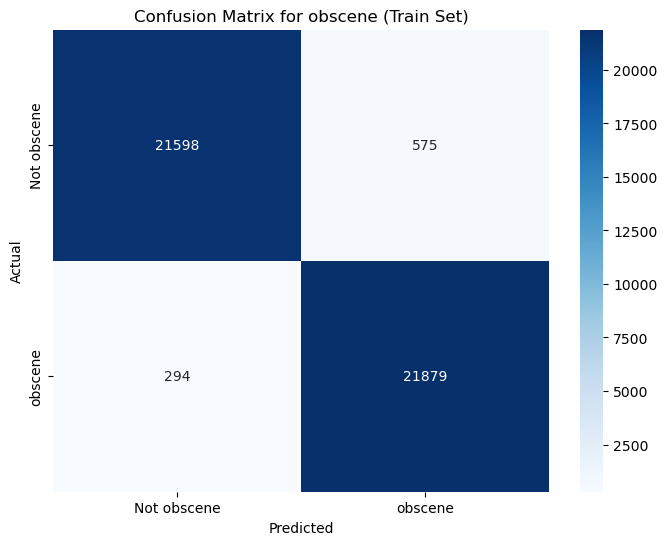

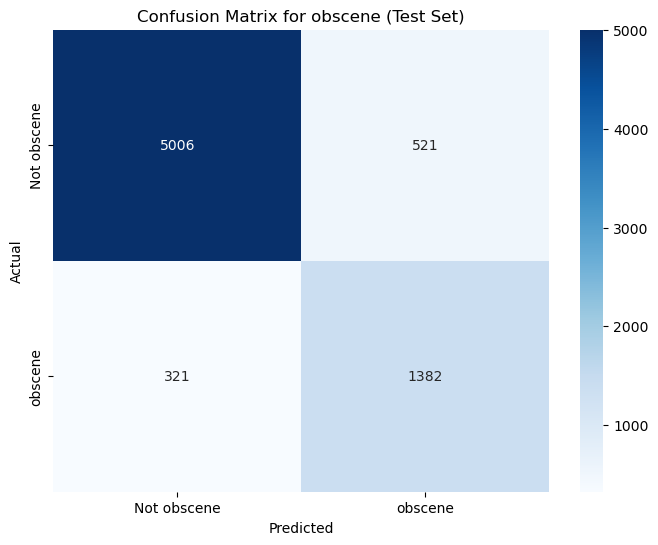

Applying SMOTE and training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for insult: {'C': 1, 'dual': False, 'penalty': 'l2'}


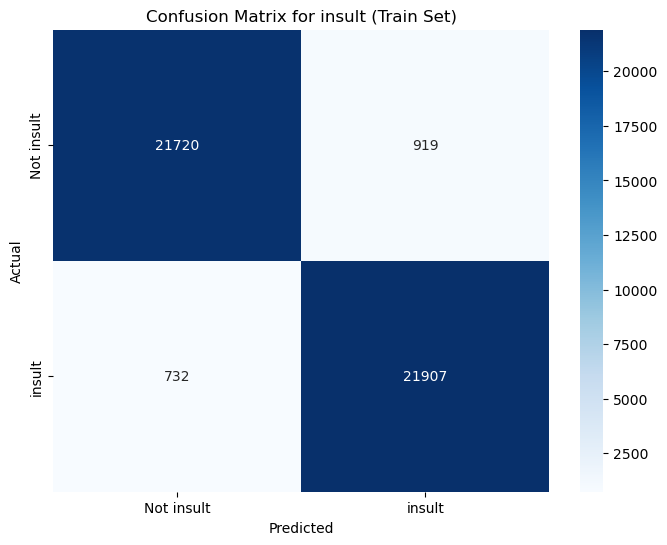

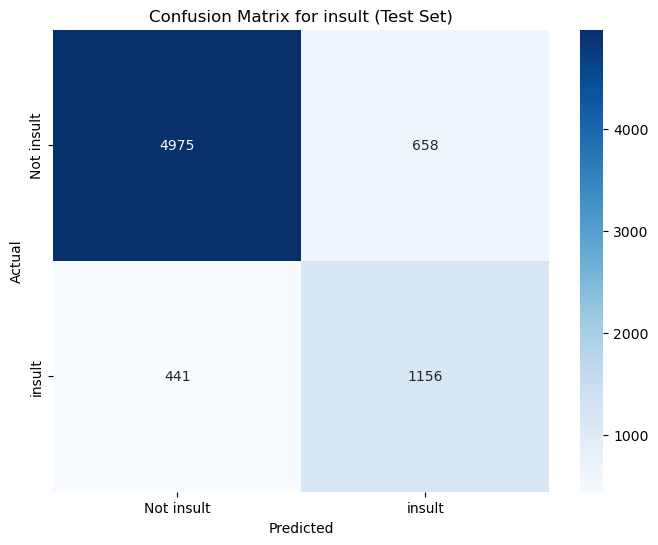


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9777
F1 Score for obscene (train set): 0.9805
F1 Score for insult (train set): 0.9637

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8528
F1 Score for obscene (test set): 0.7665
F1 Score for insult (test set): 0.6778


In [21]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # L1 and L2 regularization
    'dual': [False]                 # Necessary for 'l1' penalty
}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Set up the LinearSVC model
    svc = LinearSVC(random_state=42)

    # Set up GridSearchCV with cross-validation
    grid_search = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model from grid search
    best_svc_model = grid_search.best_estimator_

    print(f"Best parameters for {toxicity_type}: {grid_search.best_params_}")

    # Make predictions on the training set
    y_train_pred = best_svc_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_svc_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


### Increased Iteration

Applying SMOTE and training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for toxic: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l2'}


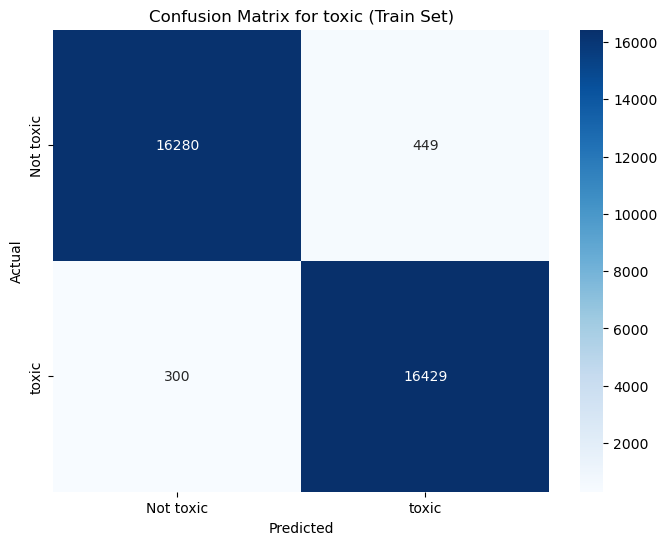

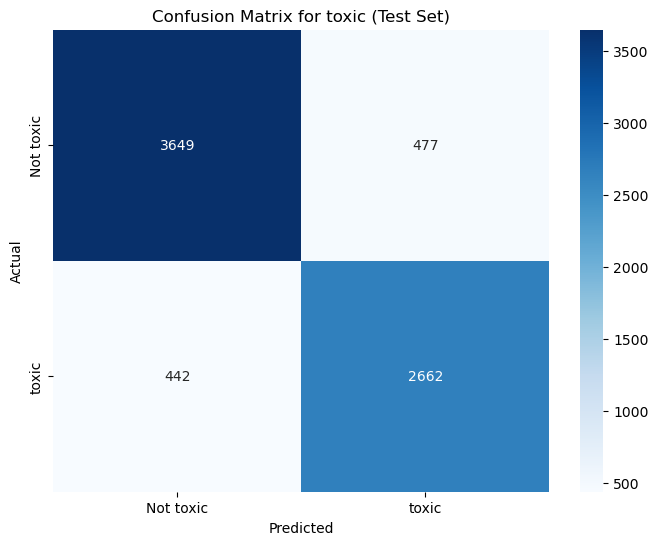

Applying SMOTE and training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for obscene: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l2'}


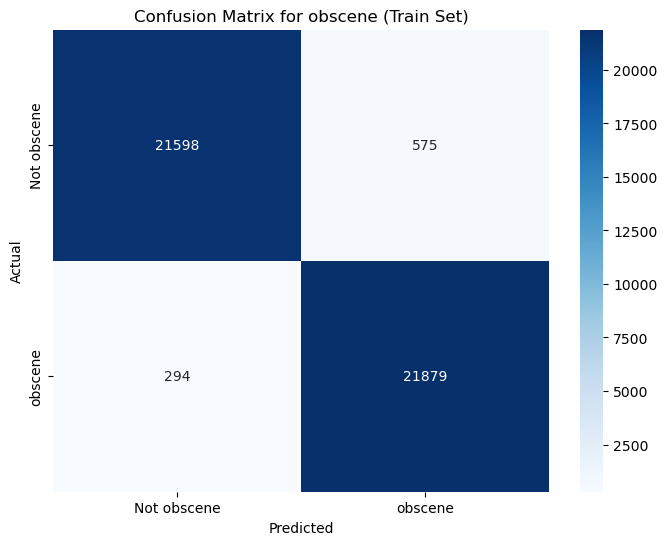

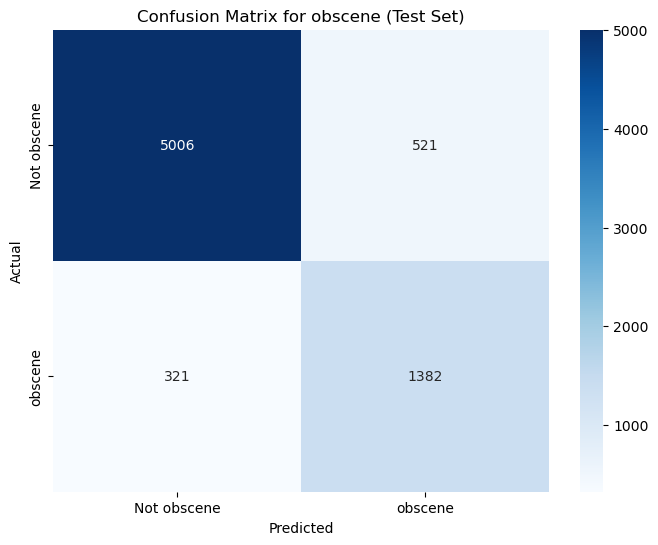

Applying SMOTE and training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for insult: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l2'}


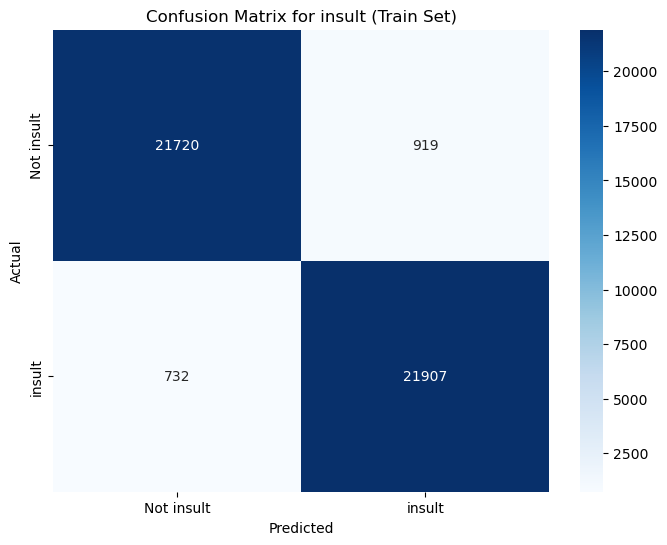

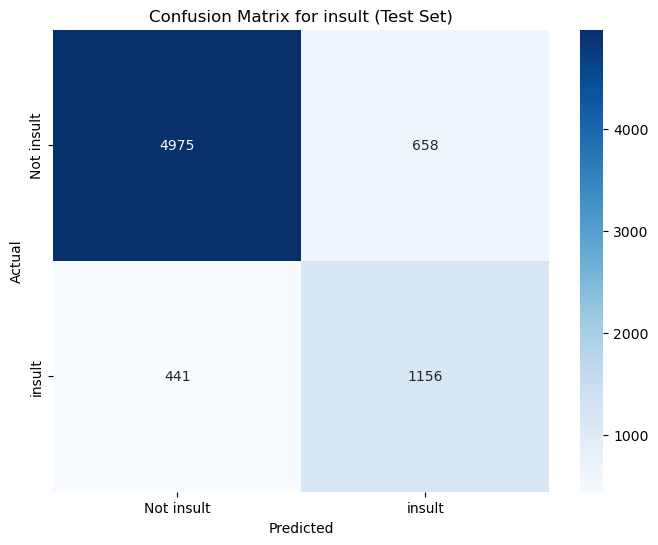


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9777
F1 Score for obscene (train set): 0.9805
F1 Score for insult (train set): 0.9637

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8528
F1 Score for obscene (test set): 0.7665
F1 Score for insult (test set): 0.6778


In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # L1 and L2 regularization
    'dual': [False],                # Necessary for 'l1' penalty
    'max_iter': [1000, 5000, 10000]  # Increase the number of iterations
}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Set up the LinearSVC model
    svc = LinearSVC(random_state=42)

    # Set up GridSearchCV with cross-validation
    grid_search = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model from grid search
    best_svc_model = grid_search.best_estimator_

    print(f"Best parameters for {toxicity_type}: {grid_search.best_params_}")

    # Make predictions on the training set
    y_train_pred = best_svc_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_svc_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


### Without SMOTE (SVM Tunning)

Training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-pack

Best parameters for toxic: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l1'}


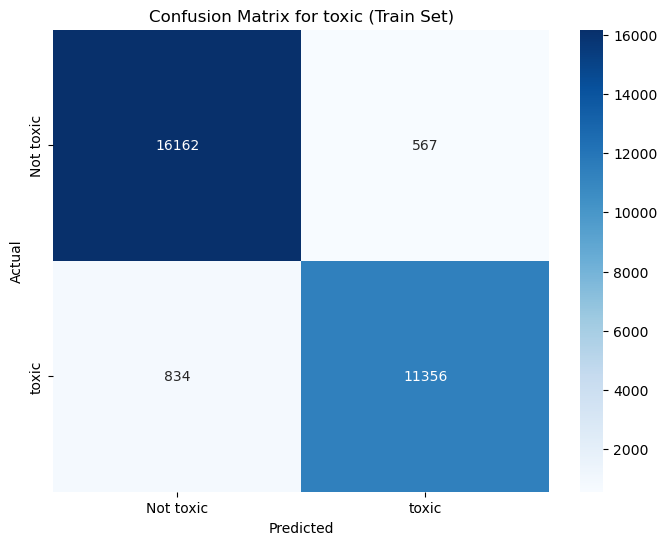

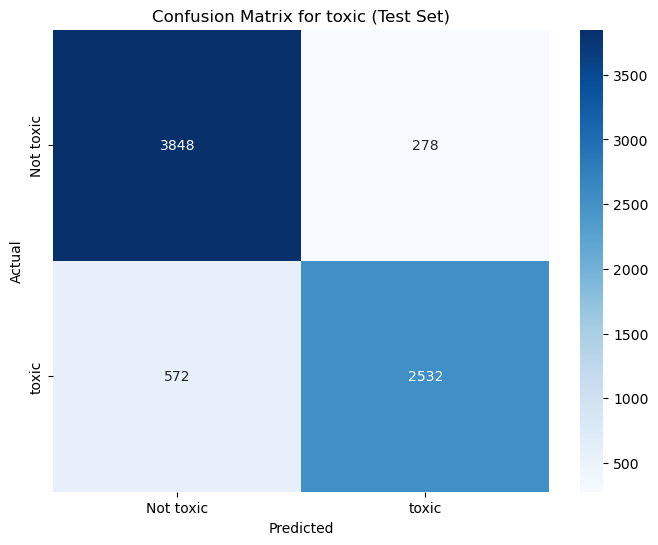

Training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-pack

Best parameters for obscene: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l1'}


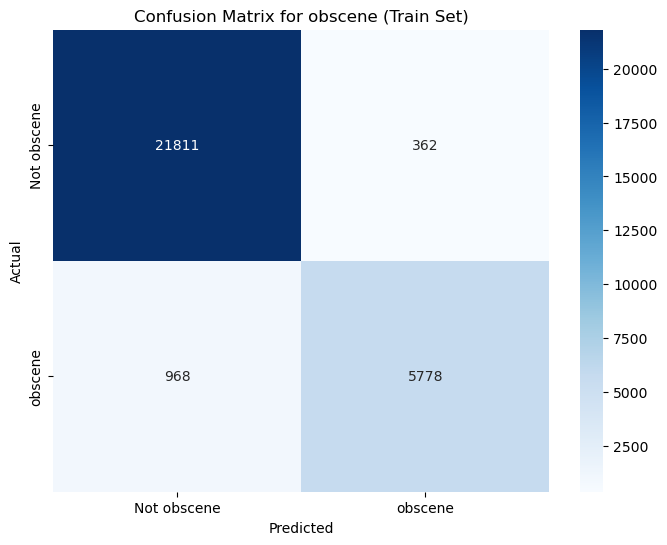

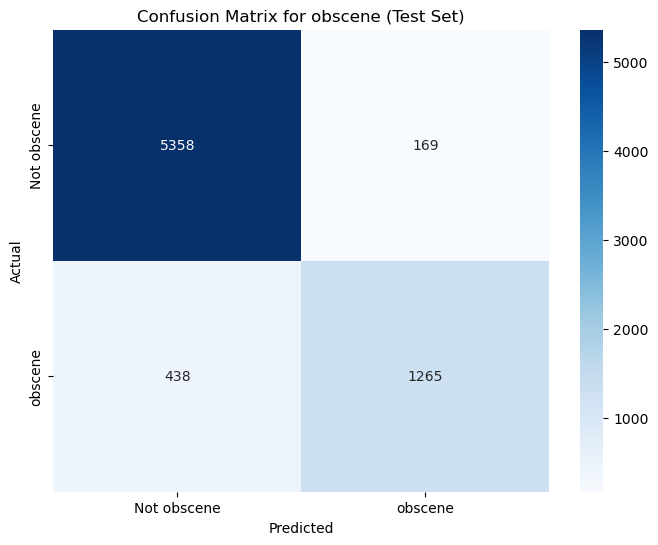

Training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-pack

Best parameters for insult: {'C': 1, 'dual': False, 'max_iter': 1000, 'penalty': 'l1'}


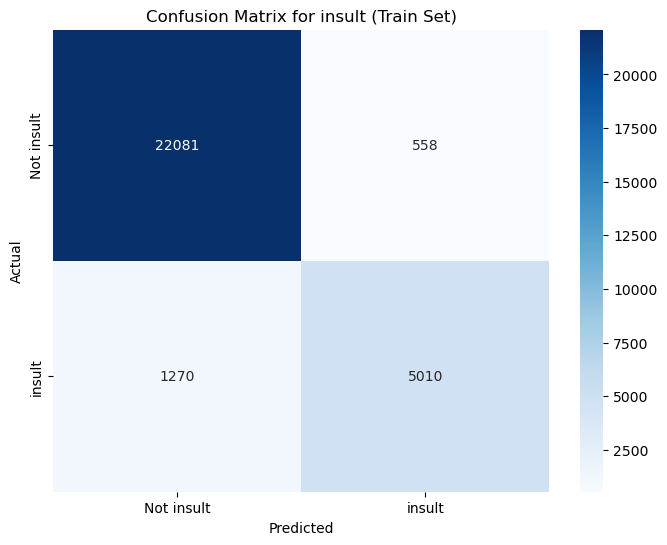

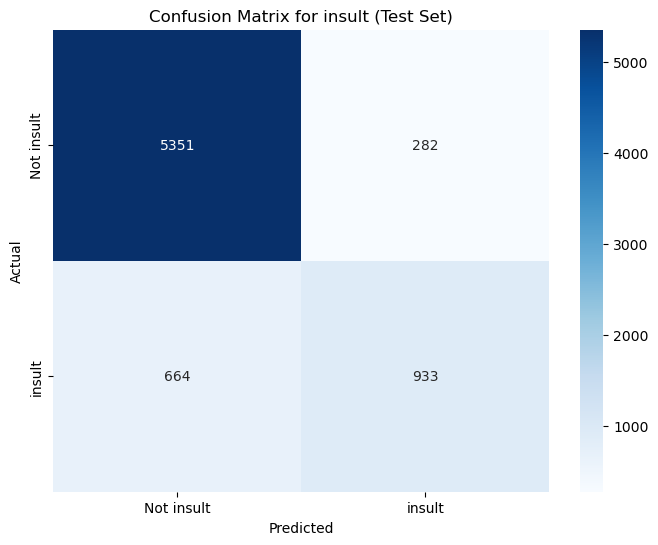


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9419
F1 Score for obscene (train set): 0.8968
F1 Score for insult (train set): 0.8457

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8563
F1 Score for obscene (test set): 0.8065
F1 Score for insult (test set): 0.6636


In [25]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # L1 and L2 regularization
    'dual': [False],                # Necessary for 'l1' penalty
    'max_iter': [1000, 5000, 10000]  # Increase the number of iterations
}

# Train and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Training for label: {toxicity_type}")

    # Set up the LinearSVC model
    svc = LinearSVC(random_state=42)

    # Set up GridSearchCV with cross-validation
    grid_search = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train[toxicity_type])
    
    # Get the best model from grid search
    best_svc_model = grid_search.best_estimator_

    print(f"Best parameters for {toxicity_type}: {grid_search.best_params_}")

    # Make predictions on the training set
    y_train_pred = best_svc_model.predict(X_train)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train[toxicity_type], y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train[toxicity_type], y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_svc_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


# Ensemble Methods

### RandomForest Clssification

### Before OverSampling

Training for label: toxic


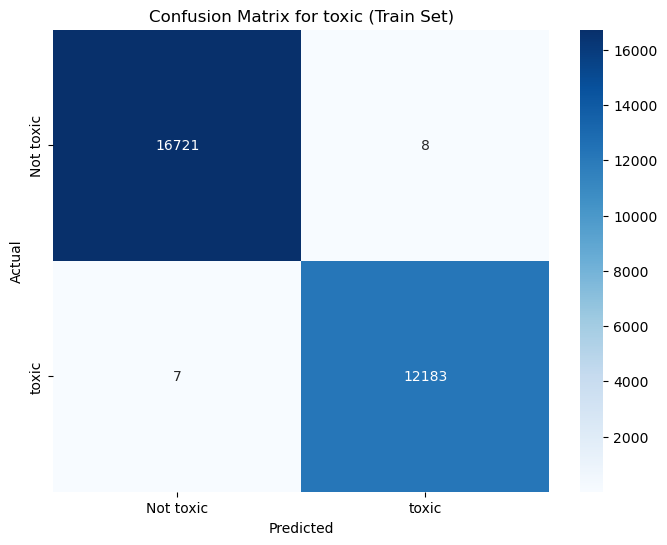

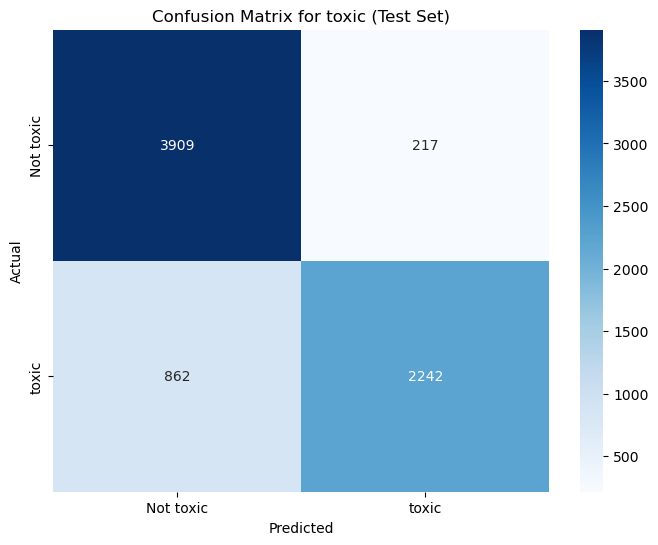

Training for label: obscene


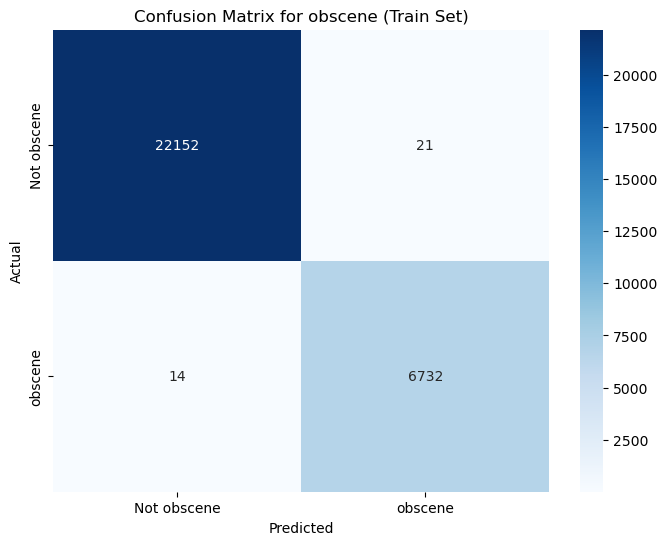

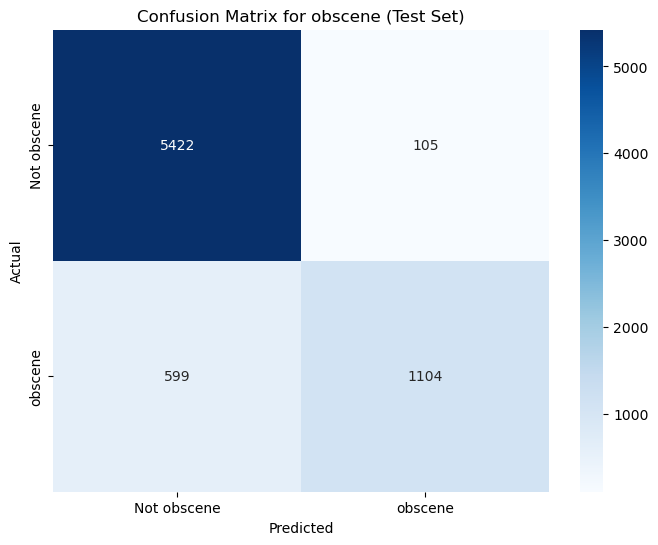

Training for label: insult


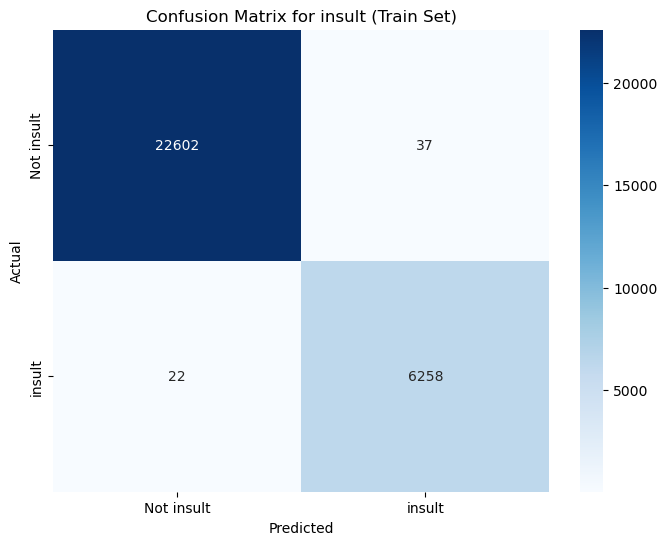

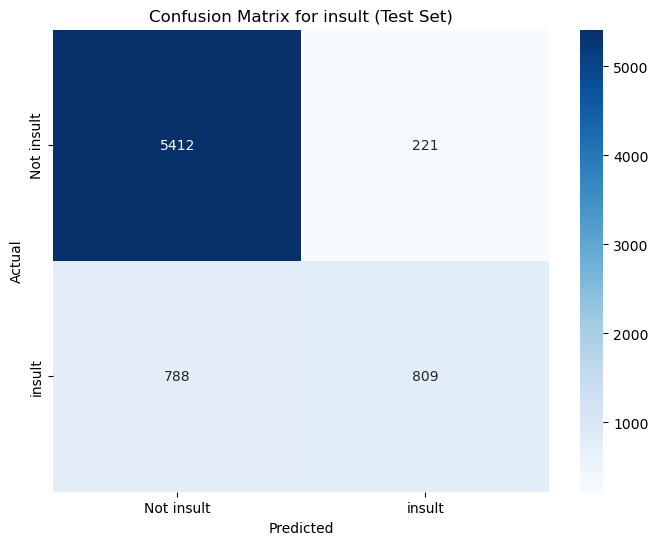


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9994
F1 Score for obscene (train set): 0.9974
F1 Score for insult (train set): 0.9953

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8060
F1 Score for obscene (test set): 0.7582
F1 Score for insult (test set): 0.6159


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Train and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Training for label: {toxicity_type}")

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train[toxicity_type])

    # Make predictions on the training set
    y_train_pred = rf_model.predict(X_train)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train[toxicity_type], y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train[toxicity_type], y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = rf_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


### After OverSampling

Applying SMOTE and training for label: toxic


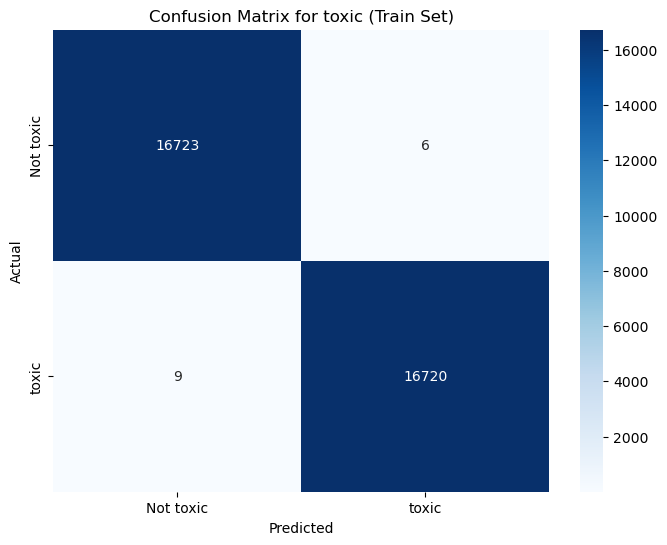

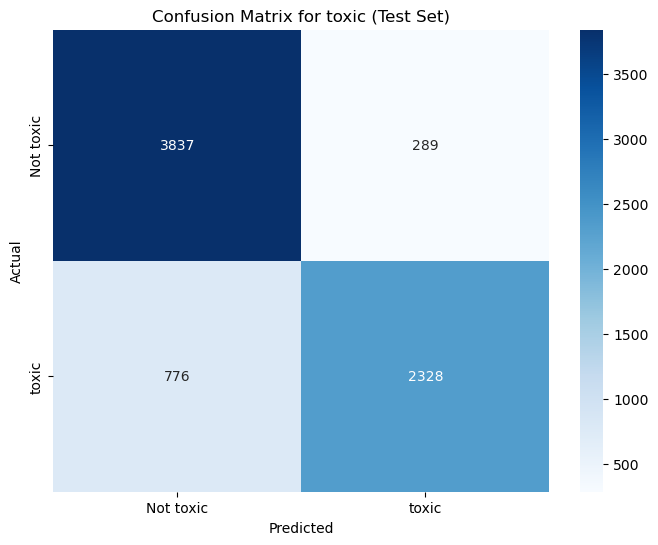

Applying SMOTE and training for label: obscene


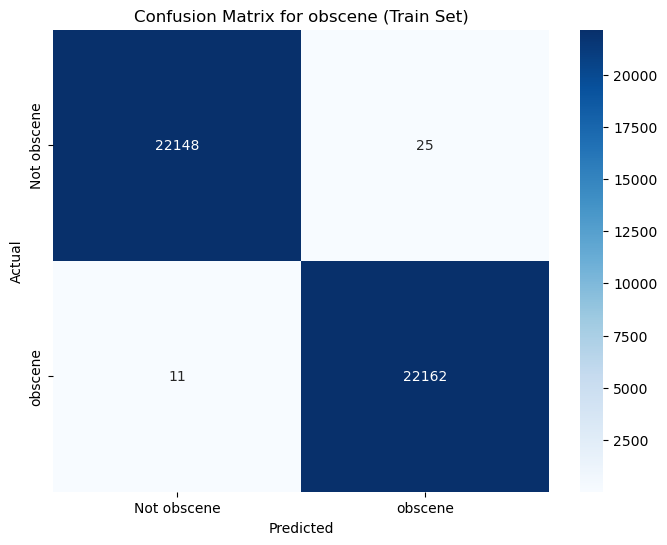

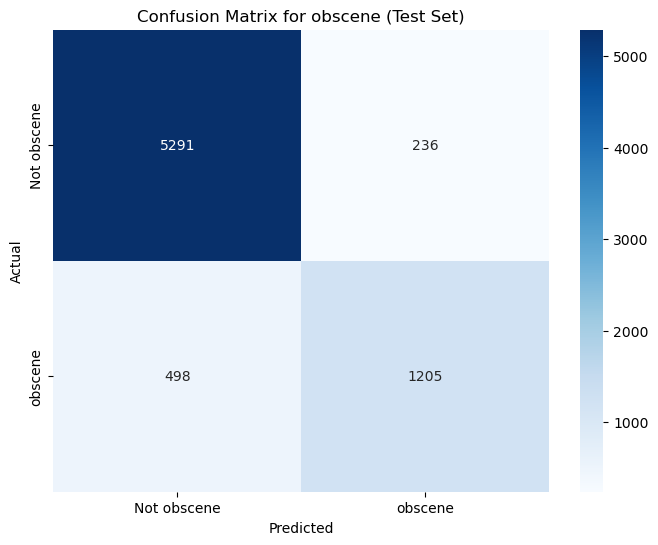

Applying SMOTE and training for label: insult


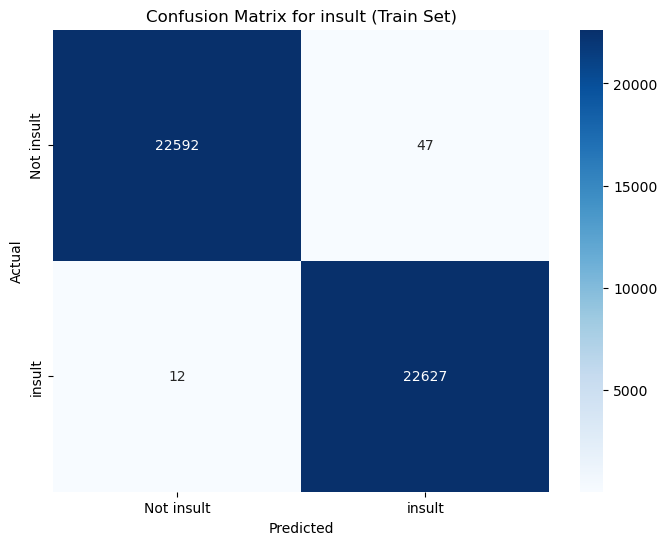

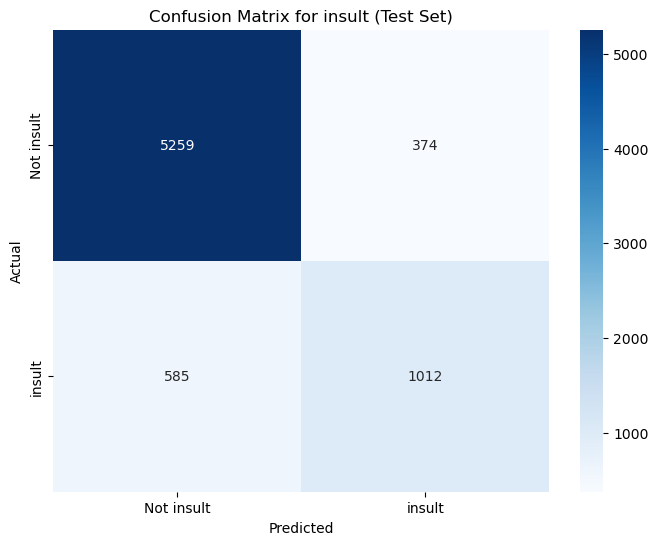


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9996
F1 Score for obscene (train set): 0.9992
F1 Score for insult (train set): 0.9987

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8138
F1 Score for obscene (test set): 0.7665
F1 Score for insult (test set): 0.6785


In [59]:
from sklearn.ensemble import RandomForestClassifier

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Train SVM model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the training set
    y_train_pred = rf_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = rf_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")

### Hyper Tunning for Random Forest

Applying SMOTE and training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
238 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

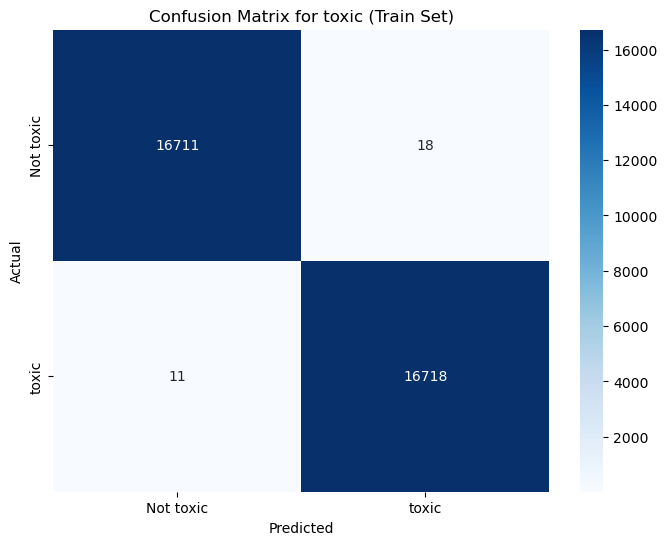

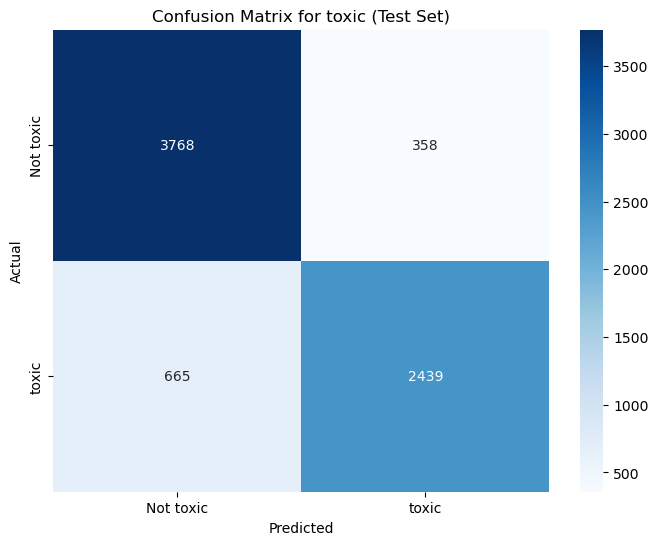

Applying SMOTE and training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_pa

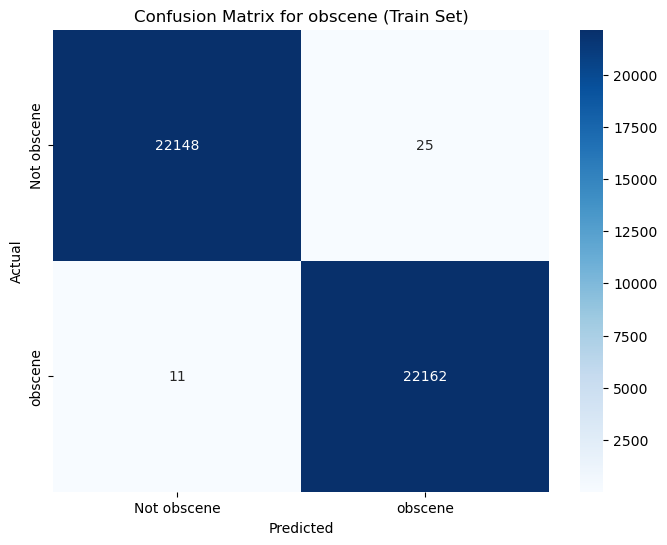

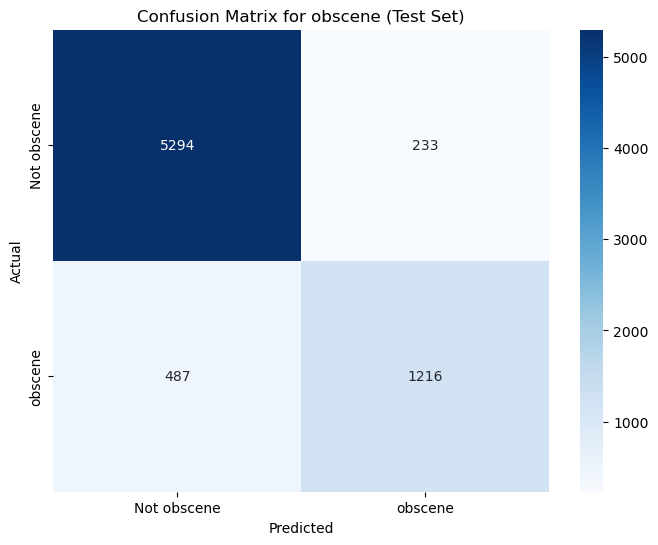

Applying SMOTE and training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
348 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fi

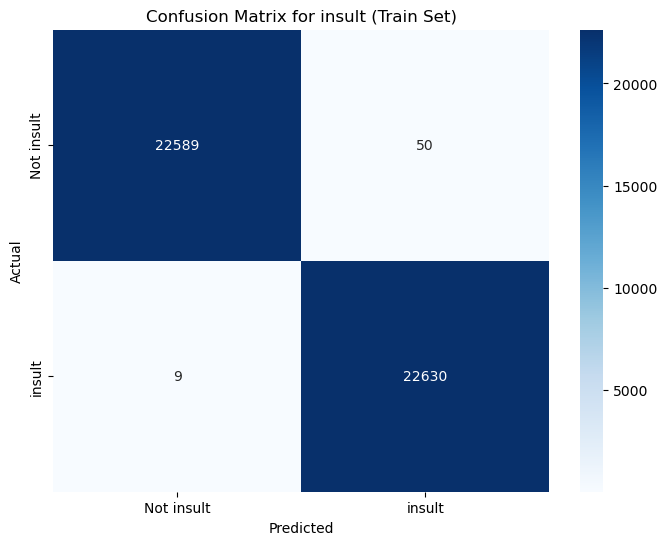

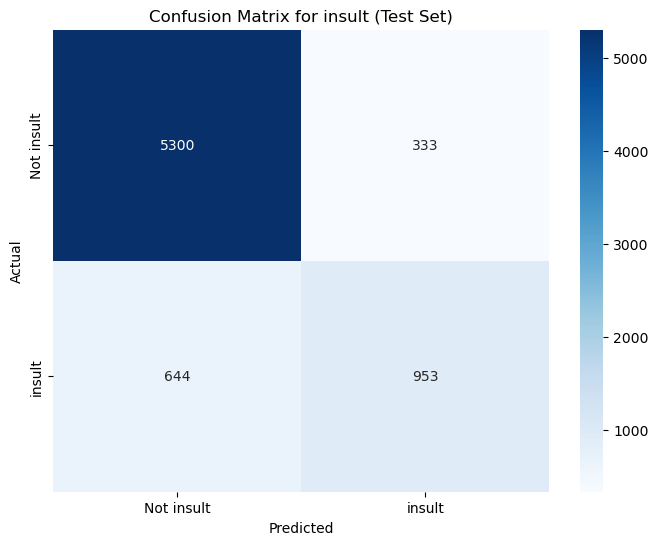


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9991
F1 Score for obscene (train set): 0.9992
F1 Score for insult (train set): 0.9987

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8266
F1 Score for obscene (test set): 0.7716
F1 Score for insult (test set): 0.6611


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Initialize RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

    # Fit GridSearchCV
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model
    best_rf_model = grid_search.best_estimator_

    # Make predictions on the training set
    y_train_pred = best_rf_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_rf_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


### AdaBoosting

Applying SMOTE and training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


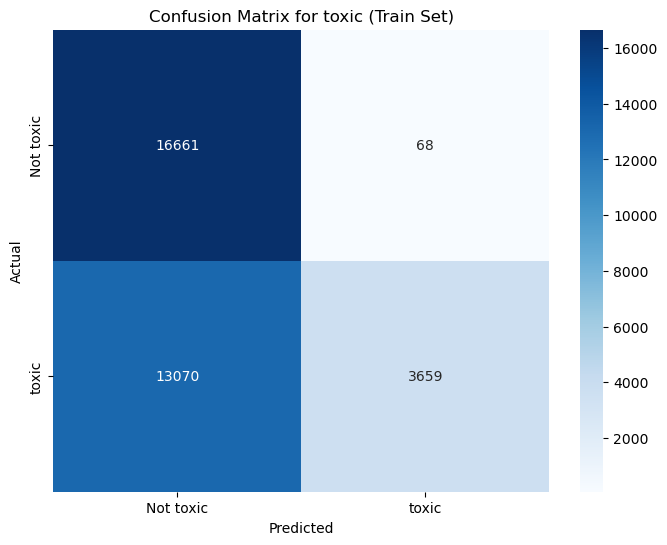

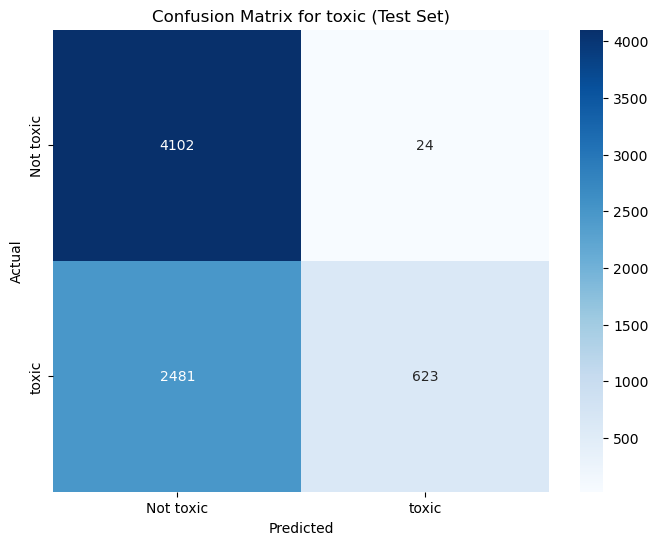

Applying SMOTE and training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


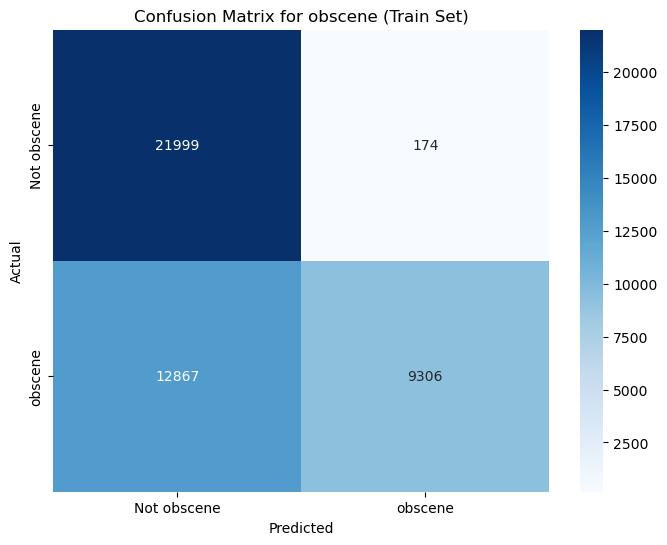

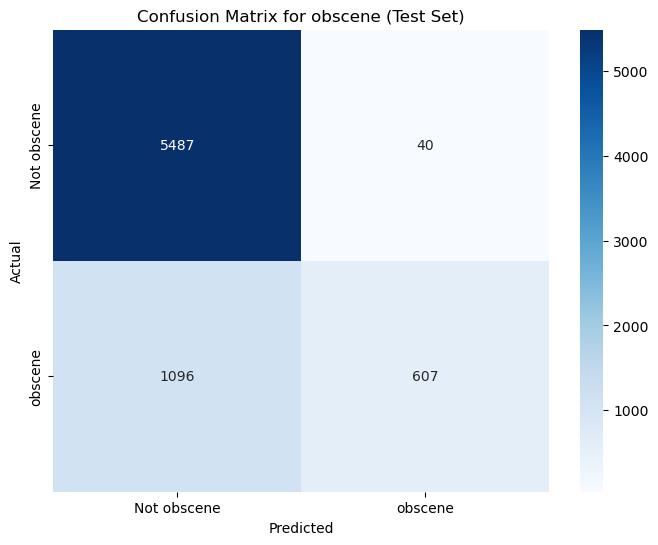

Applying SMOTE and training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


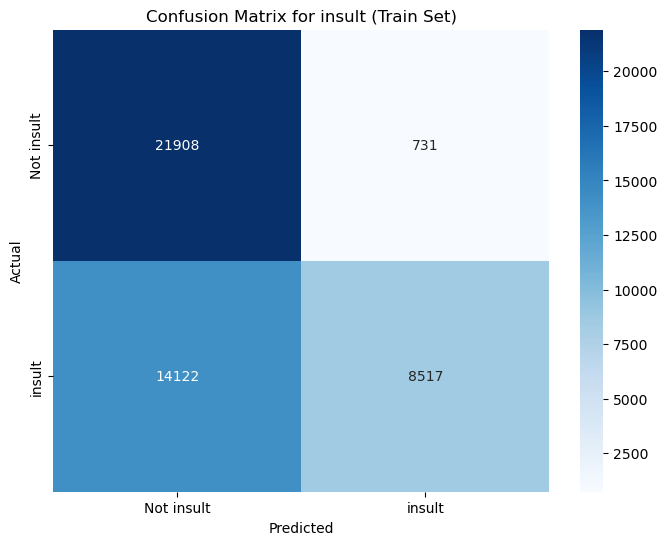

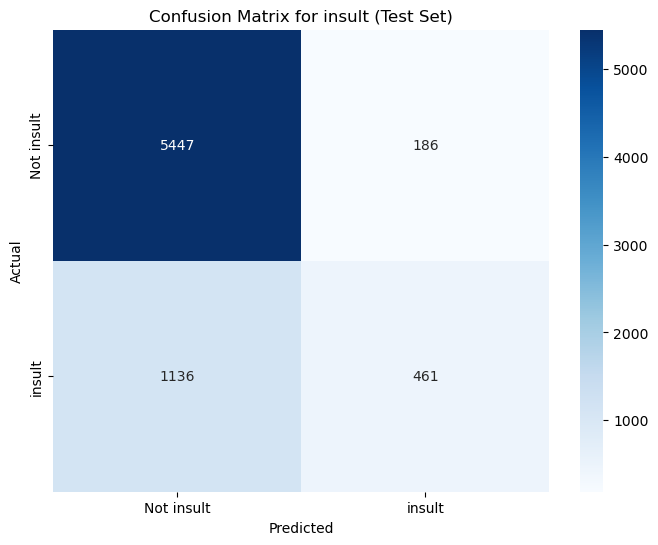


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.3577
F1 Score for obscene (train set): 0.5880
F1 Score for insult (train set): 0.5342

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.3322
F1 Score for obscene (test set): 0.5166
F1 Score for insult (test set): 0.4109


In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Train AdaBoost model with DecisionTreeClassifier as the base estimator
    adaBoost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=0.01)
    adaBoost_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the training set
    y_train_pred = adaBoost_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = adaBoost_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")


Applying SMOTE and training for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Best parameters for toxic: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


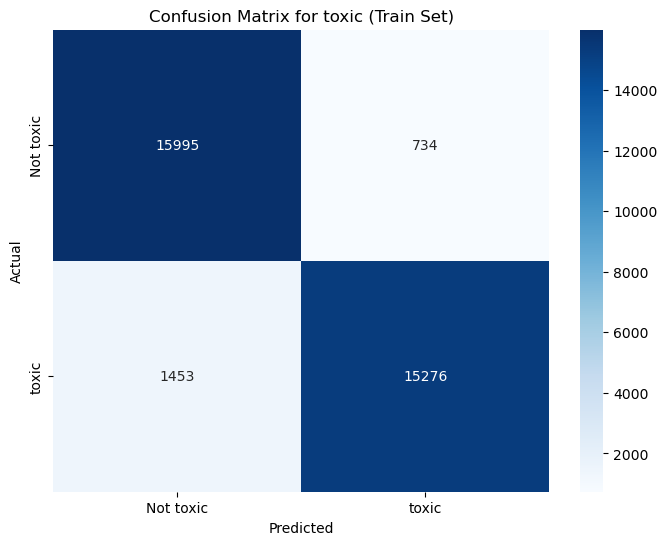

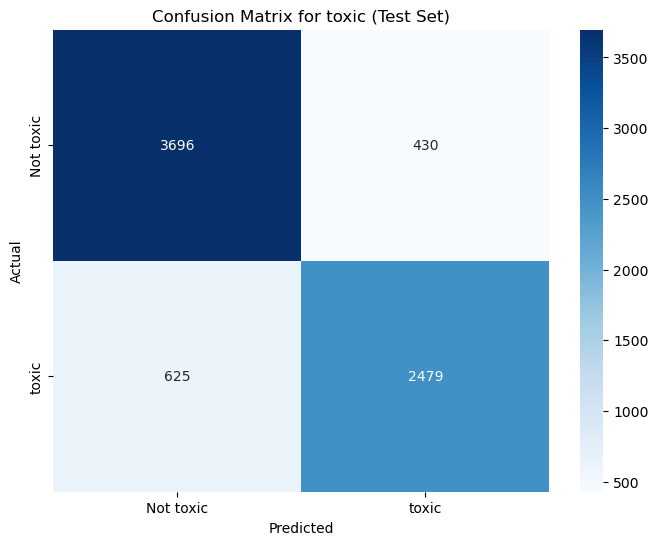

Applying SMOTE and training for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Best parameters for obscene: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


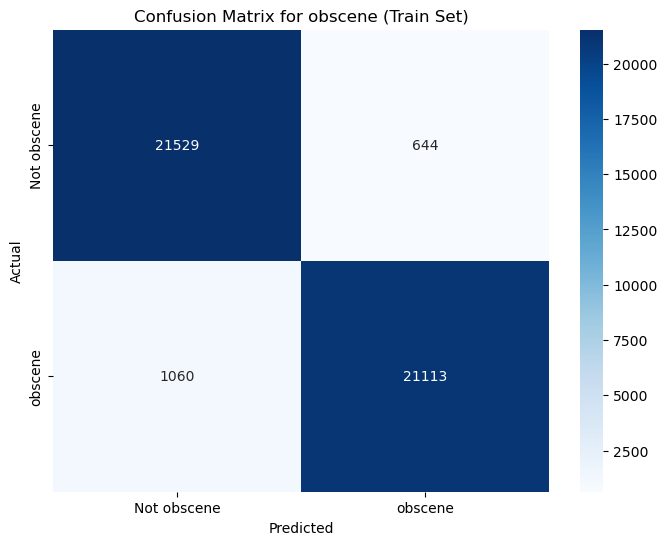

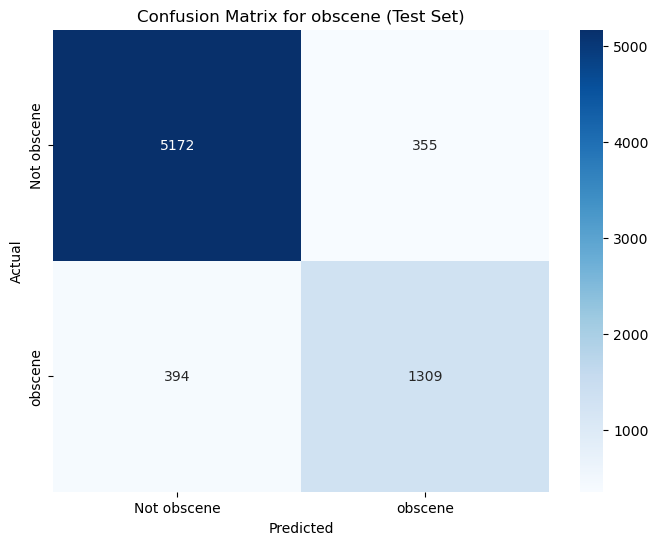

Applying SMOTE and training for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Best parameters for insult: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 200}


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


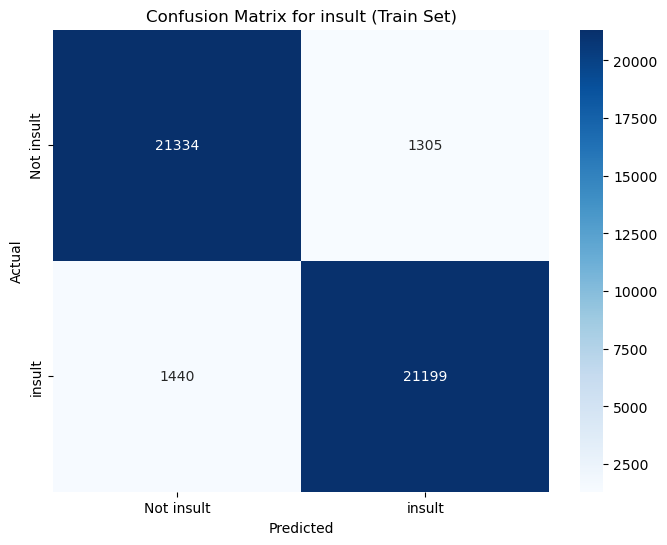

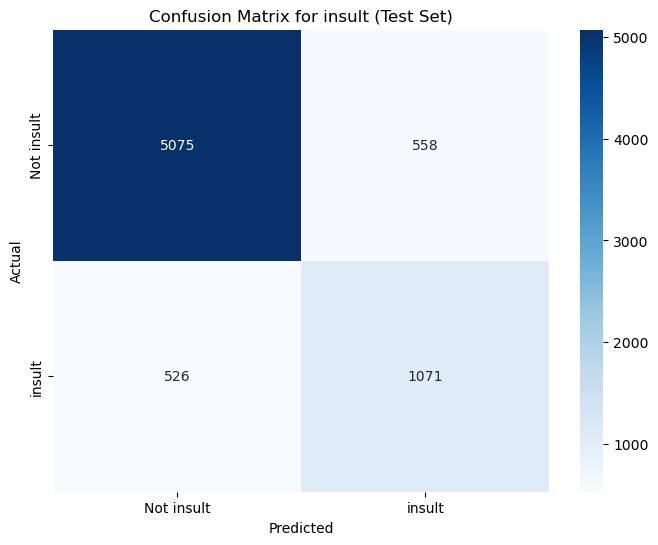


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.9332
F1 Score for obscene (train set): 0.9612
F1 Score for insult (train set): 0.9392

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.8245
F1 Score for obscene (test set): 0.7775
F1 Score for insult (test set): 0.6640


In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

smote = SMOTE(random_state=42)

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

# Apply SMOTE, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Applying SMOTE and training for label: {toxicity_type}")

    # Apply SMOTE to the specific label
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train[toxicity_type])

    # Initialize the AdaBoostClassifier with a DecisionTreeClassifier as the base estimator
    base_estimator = DecisionTreeClassifier()
    adaBoost = AdaBoostClassifier(estimator=base_estimator)

    # Initialize GridSearchCV with the parameter grid
    grid_search = GridSearchCV(estimator=adaBoost, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

    # Fit GridSearchCV to find the best parameters
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {toxicity_type}: {grid_search.best_params_}")

    # Train the best model on the resampled training data
    best_model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the training set
    y_train_pred = best_model.predict(X_train_resampled)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train_resampled, y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train_resampled, y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = best_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")

### Without oversampling 

Training and evaluating for label: toxic


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


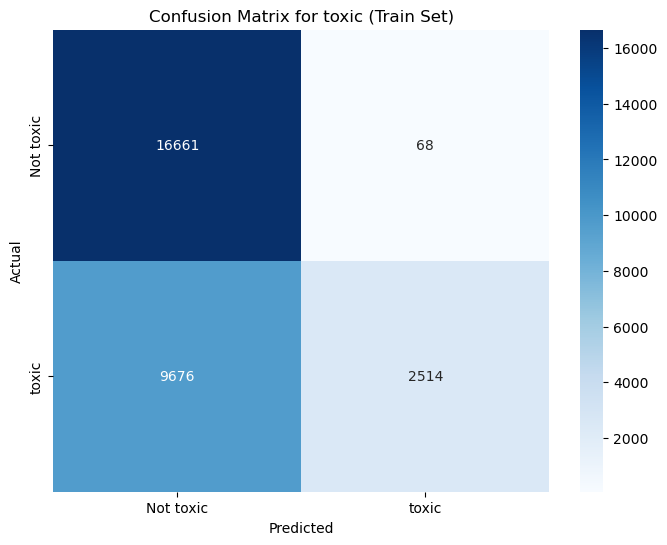

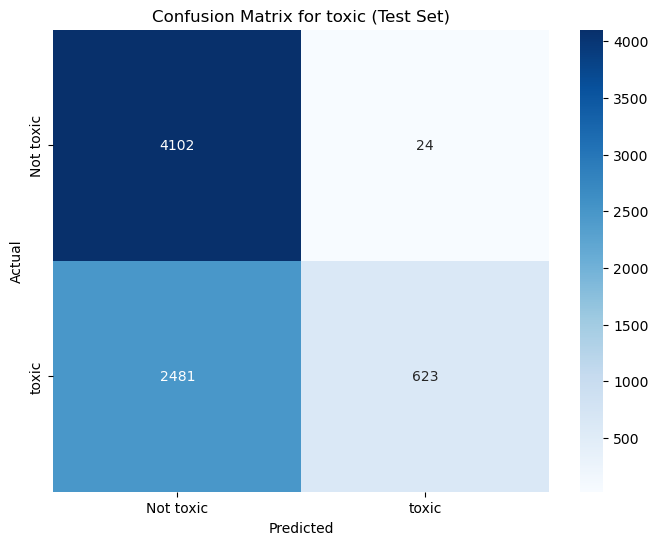

Training and evaluating for label: obscene


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


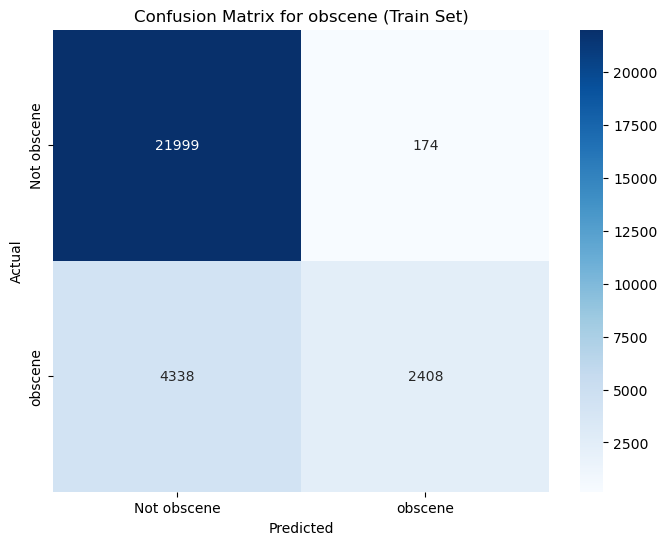

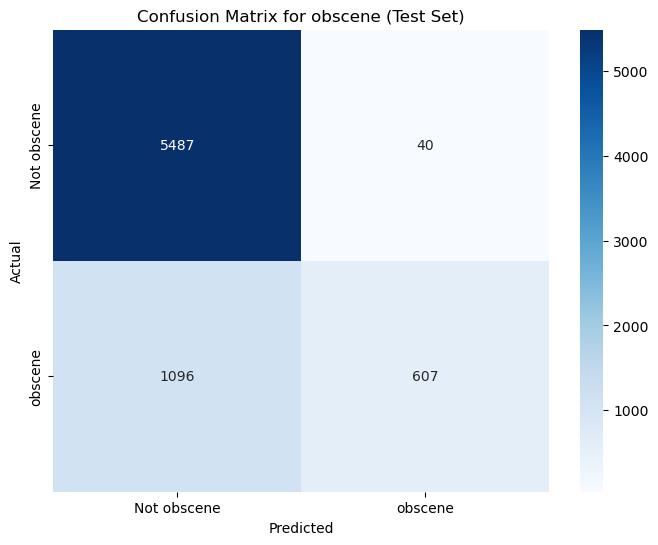

Training and evaluating for label: insult


/Users/tsheltrimpemo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


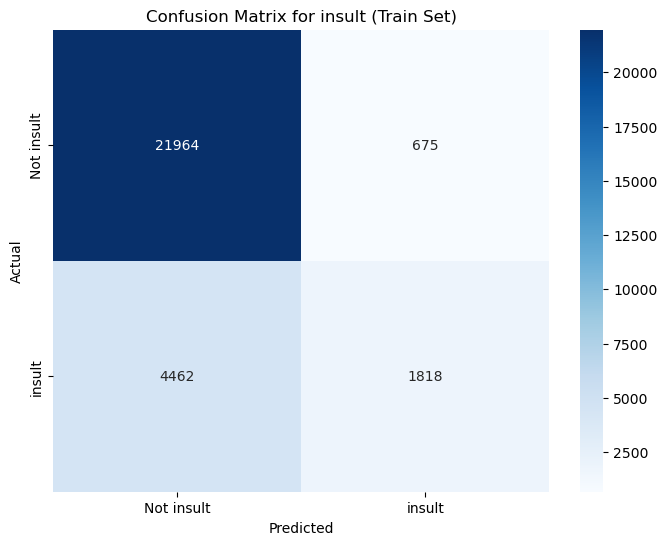

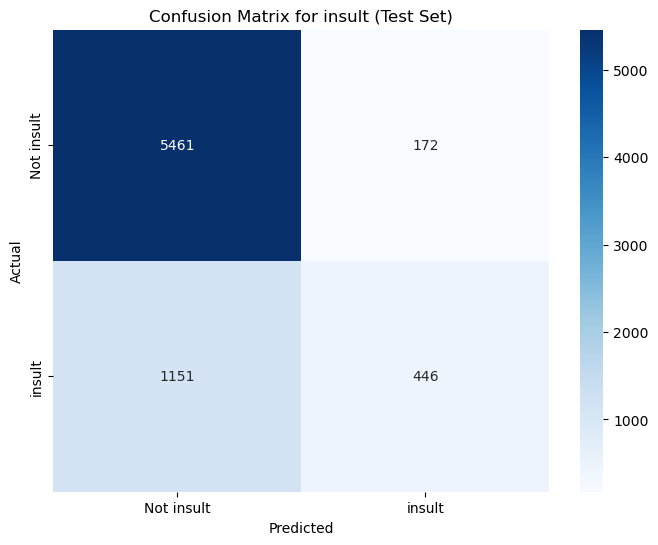


F1 Scores for Training Set:
F1 Score for toxic (train set): 0.3404
F1 Score for obscene (train set): 0.5163
F1 Score for insult (train set): 0.4145

F1 Scores for Test Set:
F1 Score for toxic (test set): 0.3322
F1 Score for obscene (test set): 0.5166
F1 Score for insult (test set): 0.4027


In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize dictionaries to store results
f1_scores_train = {}
f1_scores_test = {}
conf_matrices_train = {}
conf_matrices_test = {}

# Apply AdaBoost, train, and evaluate for each label independently
for toxicity_type in y_train.columns:
    print(f"Training and evaluating for label: {toxicity_type}")

    # Train AdaBoost model with DecisionTreeClassifier as the base estimator
    adaBoost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=0.01)
    adaBoost_model.fit(X_train, y_train[toxicity_type])

    # Make predictions on the training set
    y_train_pred = adaBoost_model.predict(X_train)

    # Calculate F1 score for the training set
    f1_train = f1_score(y_train[toxicity_type], y_train_pred)
    f1_scores_train[toxicity_type] = f1_train

    # Calculate confusion matrix for the training set
    cm_train = confusion_matrix(y_train[toxicity_type], y_train_pred)
    conf_matrices_train[toxicity_type] = cm_train

    # Make predictions on the test set
    y_test_pred = adaBoost_model.predict(X_test)

    # Calculate F1 score for the test set
    f1_test = f1_score(y_test[toxicity_type], y_test_pred)
    f1_scores_test[toxicity_type] = f1_test

    # Calculate confusion matrix for the test set
    cm_test = confusion_matrix(y_test[toxicity_type], y_test_pred)
    conf_matrices_test[toxicity_type] = cm_test

    # Plot confusion matrix as heatmap for training set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Train Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Plot confusion matrix as heatmap for test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Not ' + toxicity_type, toxicity_type], yticklabels=['Not ' + toxicity_type, toxicity_type])
    plt.title(f'Confusion Matrix for {toxicity_type} (Test Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print F1 scores for training set
print("\nF1 Scores for Training Set:")
for toxicity_type, f1 in f1_scores_train.items():
    print(f"F1 Score for {toxicity_type} (train set): {f1:.4f}")

# Print F1 scores for test set
print("\nF1 Scores for Test Set:")
for toxicity_type, f1 in f1_scores_test.items():
    print(f"F1 Score for {toxicity_type} (test set): {f1:.4f}")
